# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

Landmarks are points. And our measurement is relative position.

In [21]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca
import slam2d
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                              20
Number of constraints:                             1
Number of nonzeros in constraint Jacobian:         0
Number of nonzeros in Lagrangian Hessian:         36

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls
   0   1.929938e-04  0.00e+00  3.91e-02  0.00e+00       -  0


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   2.023092e-07   |   REM BND    5   |    19   |     0   
       1   |   3.468509e-08   |   REM BND    4   |    18   |     0   
       2   |   1.300567e-08   |   REM BND   19   |    17   |     0   
       3   |   7.718430e-11   |   REM BND   18   |    16   |     0   
       4   |   7.916338e-11   |   REM BND   17   |    15   |     0   
       5

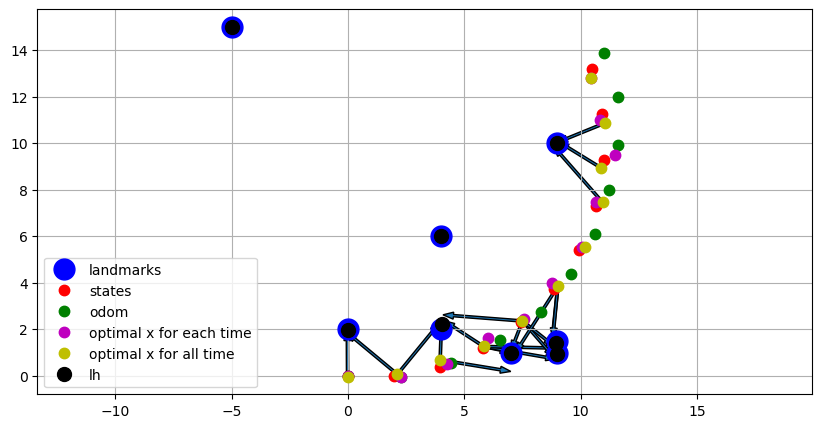

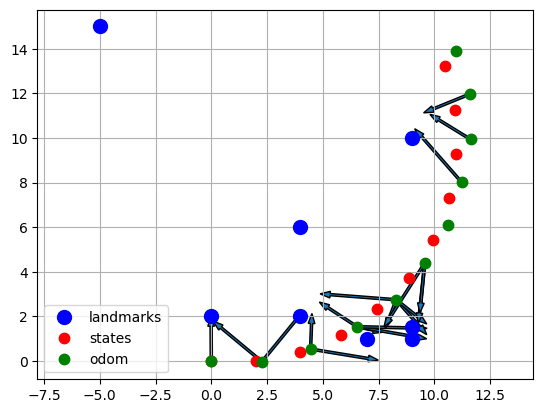

<Figure size 640x480 with 0 Axes>

In [22]:
start_time=time.time()#Method used to time simulation and optimization
#Below are the noise parameters used.  They are constant between all three runs.
noise={
    'odom_std': .05,
    'bearing_std': .05,
    'range_std': 0.02
    ,
    'odom_bx_bias': .05,
    'odom_by_bias': .05
}

plt.figure(figsize=(10, 5))

sim = slam2d.simulate(noise=noise, plot=True, tf=20);
plt.figure()
print("-----%s seconds ------" % (time.time()-start_time))#final time

In [13]:
print('x_odom')
print(sim['hist']['odom_array'])
print('x*')
print(sim['hist']['xhf'])
print('g*')
#print(np.reshape(sim['hist']['g'][1:], [7,2]))
print('lh')
print(sim['hist']['lh'])
print('J')
print(sim['hist']['J'])


x_odom
[[0.00000000e+00 0.00000000e+00]
 [2.12378356e+00 5.96666466e-04]
 [4.10298133e+00 5.71374456e-01]
 [5.95351146e+00 1.35275663e+00]
 [7.72867561e+00 2.47148584e+00]
 [9.17186443e+00 4.05044736e+00]
 [1.04053748e+01 5.86343894e+00]
 [1.09298811e+01 7.82256053e+00]
 [1.14003010e+01 9.79393735e+00]
 [1.11864793e+01 1.20108361e+01]
 [1.07067276e+01 1.39792527e+01]]
x*
[[1.08174896e-02 3.16949383e-02]
 [2.00530331e+00 4.16129368e-02]
 [3.81345461e+00 4.25117727e-01]
 [5.78119575e+00 1.04268933e+00]
 [7.53742923e+00 2.30181492e+00]
 [8.64730410e+00 4.02722998e+00]
 [9.88081446e+00 5.84022156e+00]
 [1.04053208e+01 7.79934314e+00]
 [1.08757407e+01 9.77071997e+00]
 [1.06619190e+01 1.19876187e+01]
 [1.01821673e+01 1.39560353e+01]]
g*
lh
[[[-2.16741350e-18  2.00000000e+00]
  [ 7.00000000e+00  1.00000000e+00]
  [ 4.00000000e+00  2.00000000e+00]]

 [[-1.07680642e-02  2.02962775e+00]
  [ 7.00000000e+00  1.00000000e+00]
  [ 4.01076806e+00  1.97037225e+00]]

 [[-7.76430843e-03  2.03255549e+00]


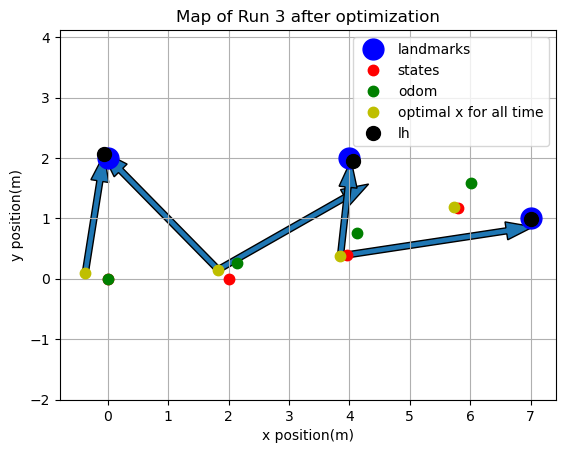

In [285]:
l = np.array([
    [0, 2],
    [7, 1],
    [4,2],
])
fig = plt.figure(1)
plt.plot(l[:, 0], l[:, 1], 'bo', label='landmarks',markersize=15)
plt.plot(sim['hist']['x'][:, 0], sim['hist']['x'][:, 1], 'r.', label='states', markersize=15)

#plot odom
x_odom = np.array([0, 0], dtype=float)
x_odom_hist = [x_odom]
for odom in sim['hist']['odom']:
    x_odom = np.array(x_odom) + np.array(odom[:2])
    x_odom_hist.append(x_odom)
x_odom_hist = np.array(x_odom_hist)
plt.plot(x_odom_hist[:, 0], x_odom_hist[:, 1], 'g.', linewidth=4, label='odom',markersize=15)
sim['hist']['odom_array']=x_odom_hist

# plot best estimate from the final time step
plt.plot(sim['hist']['xhf'][:,0], sim['hist']['xhf'][:,1], 'y.', linewidth=3, label='optimal x for all time',markersize=15)

# plot best estimate landmarks
plt.plot(sim['hist']['lh'][-1,:, 0], sim['hist']['lh'][-1,:, 1], 'ko', label='lh',markersize=10)
for rng, bearing, xi in sim['hist']['z']:
    xi = int(xi)
    #x = hist['xh'][xi, :]
    x=sim['hist']['xhf'][xi,:]
    plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
                  length_includes_head=True)
    plt.axis([5, 10, 0, 2])
    plt.grid()
    plt.title('Map of Run 3 after optimization')
    plt.xlabel('x position(m)')
    plt.ylabel('y position(m)')
    plt.legend()
    plt.axis('equal');
    l = np.array([
    [0, 2],
    [7, 1],
    [4,2],
])
fig = plt.figure(1)
plt.plot(l[:, 0], l[:, 1], 'bo', label='landmarks',markersize=15)
plt.plot(sim['hist']['x'][:, 0], sim['hist']['x'][:, 1], 'r.', label='states', markersize=15)

#plot odom
x_odom = np.array([0, 0], dtype=float)
x_odom_hist = [x_odom]
for odom in sim['hist']['odom']:
    x_odom = np.array(x_odom) + np.array(odom[:2])
    x_odom_hist.append(x_odom)
x_odom_hist = np.array(x_odom_hist)
plt.plot(x_odom_hist[:, 0], x_odom_hist[:, 1], 'g.', linewidth=4, label='odom',markersize=15)
sim['hist']['odom_array']=x_odom_hist

# plot best estimate from the final time step
plt.plot(sim['hist']['xhf'][:,0], sim['hist']['xhf'][:,1], 'y.', linewidth=3, label='optimal x for all time',markersize=15)

# plot best estimate landmarks
plt.plot(sim['hist']['lh'][-1,:, 0], sim['hist']['lh'][-1,:, 1], 'ko', label='lh',markersize=10)
for rng, bearing, xi in sim['hist']['z']:
    xi = int(xi)
    #x = hist['xh'][xi, :]
    x=sim['hist']['xhf'][xi,:]
    plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
                  length_includes_head=True)
    plt.axis([5, 10, 0, 2])
    plt.grid()
    plt.title('Map of Run 3 after optimization')
    plt.xlabel('x position(m)')
    plt.ylabel('y position(m)')
    plt.legend()
    plt.axis('equal');
    

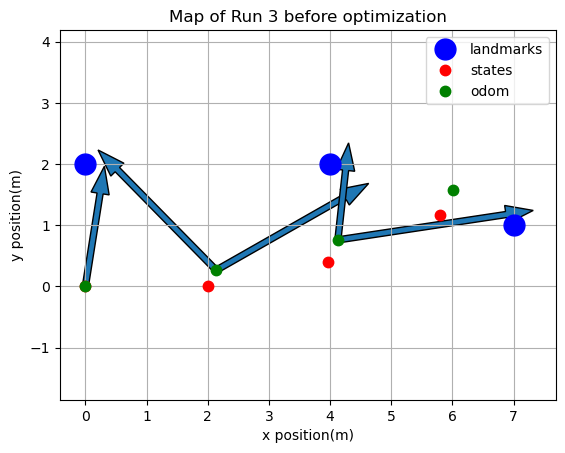

In [289]:
l = np.array([
    [0, 2],
    [7, 1],
    [4,2],
])
fig = plt.figure(1)
plt.plot(l[:, 0], l[:, 1], 'bo', label='landmarks',markersize=15)
plt.plot(sim['hist']['x'][:, 0], sim['hist']['x'][:, 1], 'r.', label='states', markersize=15)

#plot odom
x_odom = np.array([0, 0], dtype=float)
x_odom_hist = [x_odom]
for odom in sim['hist']['odom']:
    x_odom = np.array(x_odom) + np.array(odom[:2])
    x_odom_hist.append(x_odom)
x_odom_hist = np.array(x_odom_hist)
plt.plot(x_odom_hist[:, 0], x_odom_hist[:, 1], 'g.', linewidth=4, label='odom',markersize=15)
sim['hist']['odom_array']=x_odom_hist
for rng, bearing, xi in sim['hist']['z']:
    xi = int(xi)
    #x = hist['xh'][xi, :]
    x=x_odom_hist[xi,:]
    plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
                  length_includes_head=True)
    plt.axis([5, 10, 0, 2])
    plt.grid()
    plt.title('Map of Run 3 before optimization')
    plt.xlabel('x position(m)')
    plt.ylabel('y position(m)')
    plt.legend()
    plt.axis('equal');
    

In [42]:
print(sim['hist']['lh'])

[[[ 0.00000000e+00  2.00000000e+00]
  [ 9.00000000e+00  1.00000000e+00]
  [ 4.00000000e+00  2.00000000e+00]]

 [[-1.26818298e-02  1.94923090e+00]
  [ 9.00000000e+00  1.00000000e+00]
  [ 4.01268183e+00  2.05076910e+00]]

 [[-8.28096666e-03  1.94515838e+00]
  [ 9.00000000e+00  1.00000000e+00]
  [ 4.00828097e+00  2.05484162e+00]]

 [[-1.30123857e-02  1.94514083e+00]
  [ 9.04377277e+00  9.96983563e-01]
  [ 3.96923962e+00  2.05787560e+00]]

 [[-1.34883281e-02  1.94538132e+00]
  [ 9.04971768e+00  9.93509942e-01]
  [ 3.96377065e+00  2.06110873e+00]]]


In [4]:
sim['optim'].keys()

dict_keys(['f', 'g', 'lam_g', 'lam_p', 'lam_x', 'x'])

In [ ]:
# data from sim
odom = sim['hist']['odom']
l = sim['landmarks']
z = sim['hist']['z']
hist = sim['hist']

# initialize x guess from odom
x0 = sim['hist']['x']
# print(x0[:,0].shape)
x1 = x0[:,0]
x2 = x0[:,1]
l1 = l[:,0]
l2 = l[:,1]
x0_new = np.hstack([x1, x2, l1, l2])
n_x = len(hist['x'])
x0_all = np.zeros([n_x+1,2])
x0_all[1: :] = x0

# compute data associations
assoc = [ slam2d.data_association(x0_all[int(xi), :], np.array([rng, bearing]), l) for rng, bearing, xi in z ]
print(assoc)

# build cost
f_J, J = slam2d.build_cost(odom, z, assoc, x0.shape[0], l.shape[0])

# compute cost , this is where we will send it to casadi nonlinear optim
f_J(x0, l)

# Symbols/expressions
nlp = {}                 # NLP declaration
nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
nlp['f'] = J           # objective
nlp['g'] = 0             # constraints

# Create solver instance
F = ca.nlpsol('F','ipopt',nlp);

# Solve the problem using a guess
# This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
optim = F(x0=x0_new)

# Re-associate landmark/measurements given new xstar positions
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
x_allstar = np.zeros([n_x+1,2])
x_allstar[1: :] = xstar

zstar = []
for i in range(n_x):
    x = x_allstar[i,:]
    
    # measure landmarks
    z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

    for z in z_list:
        zstar.append(np.hstack([z, i]))

zstar = np.array(zstar)


new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]
print(type(new_assoc))

# # Loop through optimization and reassociation until the new association matches the old association.
# while new_assoc != assoc:
#     # build cost
#     f_J, J = slam2d.build_cost(odom, z, new_assoc, xstar.shape[0], lstar.shape[0])

#     # compute cost , this is where we will send it to casadi nonlinear optim
#     f_J(xstar, l)

#     # Symbols/expressions
#     nlp = {}                 # NLP declaration
#     nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
#     nlp['f'] = J           # objective
#     nlp['g'] = 0             # constraints

#     # Create solver instance
#     F = ca.nlpsol('F','ipopt',nlp);

#     # Solve the problem using a guess
#     # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#     xstar1 = xstar[:,0]
#     xstar2 = xstar[:,1]
#     lstar1 = l[:,0]
#     lstar2 = l[:,1]
#     xstar_new = np.hstack([xstar1, xstar2, lstar1, lstar2])
#     optim = F(x0=xstar_new)

#     # Re-associate landmark/measurements given new xstar positions
#     hist = sim['hist']
#     n_x = len(hist['x'])
#     n_l = len(sim['landmarks'])
#     xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
#     lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
#     x_allstar = np.zeros([n_x+1,2])
#     x_allstar[1: :] = xstar

#     zstar = []
#     for i in range(n_x):
#         x = x_allstar[i,:]

#         # measure landmarks
#         z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

#         for z in z_list:
#             zstar.append(np.hstack([z, i]))

#     zstar = np.array(zstar)


#     new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]


0.198451


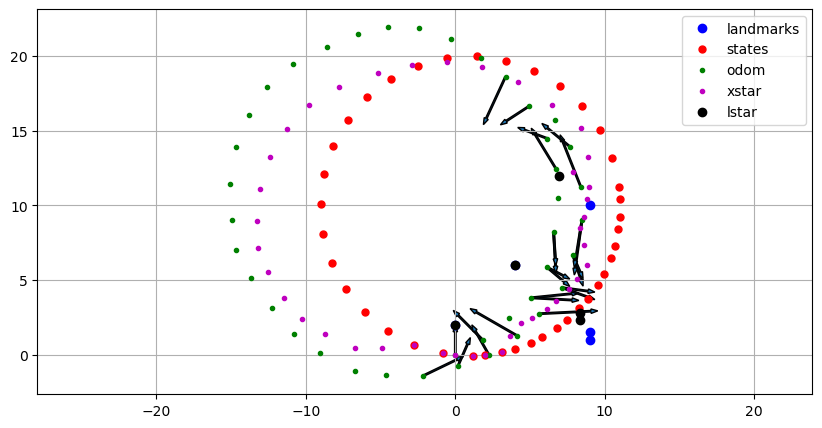

In [4]:
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.zeros([n_x+1,2])
xstar[1: :] = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
print(optim['f'])
plt.figure(figsize=(10, 5))
slam2d.plot_me(sim)
for rng, bearing, xi in hist['z']:
    xi = int(xi)
    x = xstar[xi, :]
    # plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
    #               length_includes_head=True)
plt.plot(xstar[:, 0], xstar[:, 1], 'm.', linewidth=3, label='xstar')
plt.plot(lstar[:, 0], lstar[:, 1], 'ko', label='lstar')
plt.legend()

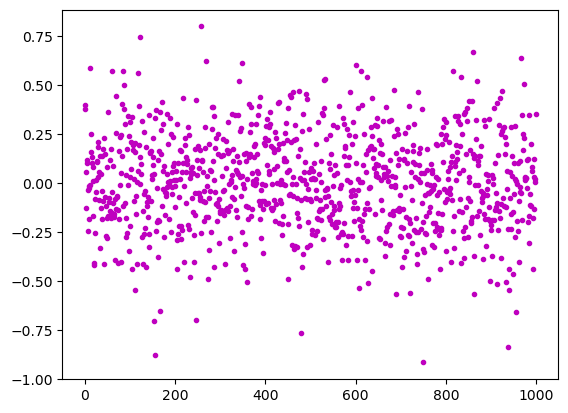

In [5]:
for lcv in range(1000):
    x = np.random.uniform(-1, 1)
    x_norm = (np.random.randn() + 0) / (4) * 1
    x2 = np.random.randn()
    # plt.plot(lcv,x,'r.')
    # plt.plot(lcv,x2,'k.')
    plt.plot(lcv,x_norm,'m.')

In [6]:
ca.__version__

'3.5.5'